In [4]:
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import rcParams
from termcolor import colored
import scipy.stats as stats
import seaborn as sns
import numpy as np  
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
from datetime import date, timedelta

In [5]:
class ForecastPetroleo():
    def __init__(self, ticker="BZ=F"):
        self.ticker = ticker        
        df_ipeadata = pd.read_csv('ipeadata[09-02-2025-09-30].csv')
        self.df = self.create_features_ipeadata(df_ipeadata)
        data_inicio = self.df.index[-1] + pd.Timedelta(days=1)
        self.df_yf = self.download_yahoo_finance(ticker, start_date=data_inicio)
        self.df = pd.concat([self.df, self.df_yf], axis=0)
        
    def fit(self):
        return self
    
    def download_yahoo_finance(self, ticker, start_date="2025-01-01"):
        data_frame = yf.download(ticker, start=start_date)        
        data_frame = self.create_features(data_frame)        
        return data_frame
    
    def create_features_ipeadata(self, df):
        data_frame = df.copy()
        data_frame.drop(columns=['Unnamed: 2'], inplace=True)
        data_frame.dropna(inplace=True)
        data_frame.columns = ['data', 'valor_fechamento']        
        data_frame['data'] = pd.to_datetime(data_frame["data"], format='%d/%m/%Y')
        data_frame['ano'] = data_frame['data'].dt.year
        data_frame['mes'] = data_frame['data'].dt.month
        data_frame['dia'] = data_frame['data'].dt.day        
        data_frame['dia_da_semana'] = data_frame['data'].dt.dayofweek
        data_frame.set_index('data', inplace=True)
        
        return data_frame      
    
    def create_features(self, df):
        data_frame = df.copy()
        data_frame["data"] = pd.to_datetime(df.index)
        data_frame['ano'] = data_frame['data'].dt.year
        data_frame['mes'] = data_frame['data'].dt.month
        data_frame['dia'] = data_frame['data'].dt.day
        data_frame.rename(columns={'Close': 'valor_fechamento'}, inplace=True)
        data_frame.rename(columns={'Open': 'valor_abertura'}, inplace=True)        
        data_frame['dia_da_semana'] = data_frame['data'].dt.dayofweek
        return data_frame

    
    def calculate_metrics(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = root_mean_squared_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred) * 100
        return mae, mse, mape


    def print_metrics(self, metrics):
        mae, mse, mape = metrics
        print(colored(f"MAE: {mae}", 'light_blue'))
        print(colored(f"MSE: {mse}", 'light_cyan'))
        print(colored(f"MAPE: {mape:.2f} %", 'light_green'))

    def prepare_data(self):
        df_feature = self.df.copy()
        df_feature.sort_values(by = 'data', inplace=True)
        feature_names = ["ano", "mes", "dia", "dia_da_semana"]
        target = "valor_fechamento"

        X = df_feature[feature_names]
        y = df_feature[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.008, shuffle=False)

        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")        

        return X_train, X_test, y_train, y_test
    
    def train_model(self, X_train, y_train):
        model = xgb.XGBRegressor(objective="reg:squarederror")
        model.fit(X_train, y_train)
        return model
    
    def evaluate_model(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        mae, mse, mape = self.calculate_metrics(y_test, y_pred)
        self.print_metrics((mae, mse, mape))
        return y_pred    
    
    def plot_predictions_with_test(self, y_test, y_pred):
        plt.plot(y_test.index, y_test, label="Valor Real")
        plt.plot(y_test.index, y_pred, label="Valor Previsto_teste")        
        plt.legend()
        plt.xticks(rotation=45, ha='right') 
        plt.show()
    
    def plot_predictions(self, y_pred):
        plt.plot(y_pred.index, y_pred['valor_fechamento'], label="Valor Previsto")
        plt.legend()
        plt.xticks(rotation=45, ha='right') 
        plt.show()
        

    def configure_days(self, first_date, num_days=1):        

          # Converte a data inicial para o tipo datetime, se necessário
        if isinstance(first_date, str):
            first_date = pd.to_datetime(first_date)

        # Cria um range de datas futuras
        future_dates = pd.date_range(start=first_date, periods=num_days + 1)

        # Remove a data inicial, deixando apenas as datas futuras
        future_dates = future_dates[1:]

        return future_dates
    def prepare_dates(self, dates):
        df_feature = pd.to_datetime(dates)
        df_feature = df_feature.to_frame()
        df_feature['ano'] = df_feature.index.year
        df_feature['mes'] = df_feature.index.month
        df_feature['dia'] = df_feature.index.day
        df_feature['dia_da_semana'] = df_feature.index.dayofweek
        df_feature.reset_index(drop=True, inplace=True)
        df_feature.drop(columns=[0], inplace=True)
        
        return df_feature

    def final_predictions(self, dates_for_predict,y_pred_final):
        df_final = pd.merge(dates_for_predict, pd.DataFrame(y_pred_final), left_index=True, right_index=True)
        df_final['data'] = df_final['ano'].astype(str) + '-' + df_final['mes'].astype(str).str.zfill(2) + '-' + df_final['dia'].astype(str).str.zfill(2)
        df_final['data'] = pd.to_datetime(df_final['data'], format='%Y-%m-%d')

        df_final = df_final.set_index('data')
        df_final.rename(columns = {0: 'valor_fechamento'}, inplace=True)

        return df_final

    def predict_days(self, days=10):
        X_train, X_test, y_train, y_test = self.prepare_data()
        model = self.train_model(X_train, y_train)
        y_pred = self.evaluate_model(model, X_test, y_test)
        
        dates_for_predict = self.configure_days(self.df.index[-1], days)        
        dates_for_predict = self.prepare_dates(dates_for_predict)
        y_pred_final = model.predict(dates_for_predict)
        self.plot_predictions_with_test(y_test, y_pred)        
        df_final_predict  = self.final_predictions(dates_for_predict, y_pred_final)
        
        self.plot_predictions(df_final_predict)
        
        
        return df_final_predict


[*********************100%***********************]  1 of 1 completed


X_train: (11266, 4)
X_test: (91, 4)
MAE: 3.5197355266193764
MSE: 4.481758319813407
MAPE: 4.61 %


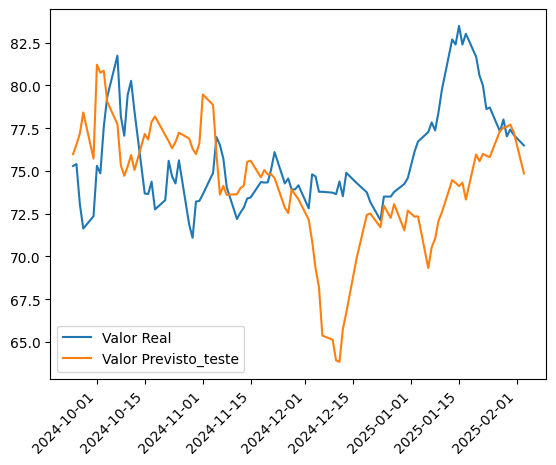

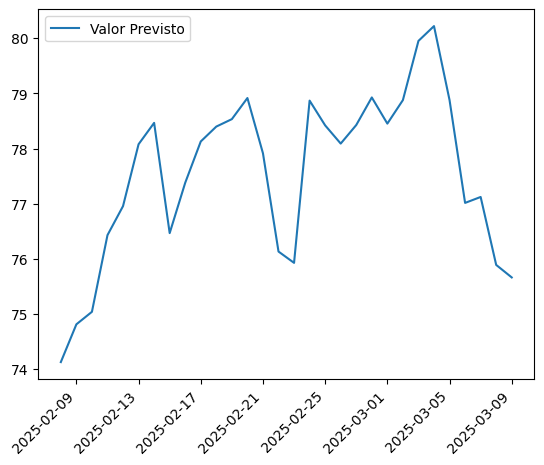

,ano,mes,dia,dia_da_semana,valor_fechamento
data,,,,,
2025-02-08,2025,2,8,5,74.125763
2025-02-09,2025,2,9,6,74.810944
2025-02-10,2025,2,10,0,75.038078
2025-02-11,2025,2,11,1,76.428688
2025-02-12,2025,2,12,2,76.955292
2025-02-13,2025,2,13,3,78.077744
2025-02-14,2025,2,14,4,78.465500
2025-02-15,2025,2,15,5,76.465569
2025-02-16,2025,2,16,6,77.379387


In [6]:
forecast = ForecastPetroleo()
forecast.predict_days(30)